In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import datetime as dt
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

nsepy's get_history() function seems to have some problem, it keeps on running without giving any output or just an empty dataframe as an output.
Luckily though, using get_price_list()  first seems to establish connection with the nse website and then get_history() works fine.

In [2]:
filename = "./data/set1-xgboost.csv"

df = pd.read_csv(filename)
print(df)

           date       open       high        low      close     volume   
0     7/23/2012  21.228571  21.639286  20.989643  21.565357  487975600  \
1     7/24/2012  21.692142  21.774286  21.375357  21.461430  565132400   
2     7/27/2012  20.536072  20.922501  20.413929  20.898571  403936400   
3     7/30/2012  21.104286  21.408571  20.993570  21.251072  379142400   
4     7/31/2012  21.543928  21.846430  21.525715  21.812857  462327600   
...         ...        ...        ...        ...        ...        ...   
1525  1/17/2020  79.067497  79.684998  78.750000  79.682503  137816400   
1526  1/21/2020  79.297501  79.754997  79.000000  79.142502  110843200   
1527  1/22/2020  79.644997  79.997498  79.327499  79.425003  101832400   
1528  1/23/2020  79.480003  79.889999  78.912498  79.807503  104472000   
1529  1/24/2020  80.062500  80.832497  79.379997  79.577499  146537600   

       adjclose  prev_close  
0     18.257217   21.565357  
1     18.169228   21.565357  
2     17.692717   21.

In [3]:
# Feature engineering
df['EMA_9'] = df['close'].ewm(9).mean().shift()
df['SMA_5'] = df['close'].rolling(5).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_15'] = df['close'].rolling(15).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

In [4]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

In [5]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [6]:
df.drop("volume", axis=1, inplace=True)

# Train test split

In [7]:
# Splitting the dataset into 70% training, 15% validation and 15% test
# train test split indexes
test_size  = 0.2
valid_size = 0.1

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))  


#train test split tcs

train= df.loc[:valid_split_idx]
valid= df.loc[valid_split_idx+1:test_split_idx]
test= df.loc[test_split_idx+1:]

In [8]:
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

valid['date'] = pd.to_datetime(valid['date'])
valid.set_index('date', inplace=True)

test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_13232\2669687655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_13232\2669687655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['date'] = pd.to_datetime(valid['date'])
C:\Users\User\AppData\Local\Temp\ipykernel_13232\2669687655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
y_train = train['close']
X_train = train.drop(['close'], axis=1)

y_valid = valid['close']
X_valid = valid.drop(['close'], axis=1)

y_test = test['close']
X_test = test.drop(['close'],axis=1)

# XGBoost Model


In [40]:
parameters = {
    'n_estimators': [100, 300,500],
    'learning_rate': [0.1, 0.01, 0.005],
    'max_depth': [8, 12, 15],
    'gamma': [ 0.005, 0.01,],
    'random_state': [42],
    'min_child_weight':[4,3],
    'subsample':[0.8,1],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
kfold=KFold(5)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf = GridSearchCV(model, parameters,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.005, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300, 'random_state': 42, 'subsample': 0.8}
Best validation score = -1.4320580746343023


In [42]:
model = XGBRegressor(**clf.best_params_, objective='reg:squarederror',n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred=model.predict(X_test)
mean_squared_error(y_test,y_pred)

158.09599251014856

In [12]:
print(y_pred)

[43.7587   43.758293 43.7637   43.759357 43.760075 43.777058 43.76906
 43.77234  43.781662 43.781662 43.781662 43.781662 43.786274 43.779854
 43.773506 43.76992  43.77634  43.783848 43.77891  43.786095 43.794285
 43.79156  43.787407 43.789135 43.791443 43.79448  43.777046 43.77121
 43.768173 43.768173 43.768173 43.768173 43.76383  43.766384 43.768784
 43.76383  43.76689  43.76689  43.763653 43.75333  43.75333  43.749043
 43.74844  43.74844  43.74844  43.749043 43.749043 43.349686 43.34743
 43.208054 43.751667 43.751163 43.749043 43.74844  43.74844  43.20275
 42.731033 42.419903 42.56394  42.756596 42.977684 41.95178  41.94014
 41.35108  41.571613 39.922836 38.102684 37.35601  39.25997  39.218384
 39.388557 39.997116 39.961063 36.209167 37.559494 37.738422 37.955246
 38.790142 38.672684 37.921658 38.78187  39.24859  39.339066 39.67602
 38.92902  38.94373  38.806175 39.87857  39.30821  39.250168 40.692596
 41.884438 41.880096 42.733833 43.371513 43.081802 42.930256 43.05267
 43.143024 43

In [34]:
def write_pred_actual_csv(merged_df):
    filename = f"./output/pred-actual/xg-boost.csv"
    merged_df.to_csv(filename)


In [18]:
print(y_test)

date
2018-09-10    54.582500
2018-09-11    55.962502
2018-09-13    56.602501
2018-09-14    55.959999
2018-09-17    54.470001
                ...    
2020-01-17    79.682503
2020-01-21    79.142502
2020-01-22    79.425003
2020-01-23    79.807503
2020-01-24    79.577499
Name: close, Length: 305, dtype: float64


In [35]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['pred'])
merged_df = pd.concat([y_test, y_pred_df], axis=1)




In [38]:
print(merged_df)

                close       pred
date                            
2018-09-10  54.582500  43.758701
2018-09-11  55.962502  43.758293
2018-09-13  56.602501  43.763699
2018-09-14  55.959999  43.759357
2018-09-17  54.470001  43.760075
...               ...        ...
2020-01-17  79.682503  43.794136
2020-01-21  79.142502  43.797447
2020-01-22  79.425003  43.797447
2020-01-23  79.807503  43.799026
2020-01-24  79.577499  43.797447

[305 rows x 2 columns]


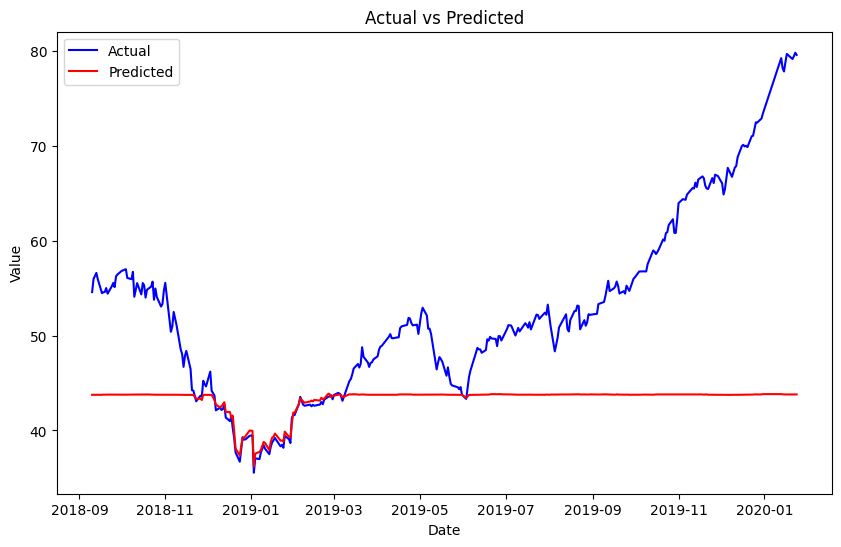

In [43]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y_test
plt.plot(merged_df.index, merged_df['close'], label='Actual', color='blue')

# Plot y_pred
plt.plot(merged_df.index, merged_df['pred'], label='Predicted', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()

# Display the plot
plt.show()

In [36]:
write_pred_actual_csv(merged_df)